### Environment setting

In [ ]:
!pip install -r requirements.txt

In [1]:
IMAGE_SIZE = 300
IMAGE_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3)
LABELS = ['No', 'Yes']
MODEL_PATH = 'models/HE/resnet-{}.h5'.format(IMAGE_SIZE)
#DATASET_PATH = 'data/2021_STUDY/HE/test'
DATASET_PATH = 'data/2021_STUDY/HELDOUT'

### Load model

In [2]:
from tensorflow.keras.models import load_model

model = load_model(MODEL_PATH)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 10, 10, 2048)      23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               262272    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                2064      
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 1

### Load the testing dataset

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import preprocess_input

def load_dataset(folder, labels, target_size=None):
    datagen = ImageDataGenerator(
        rescale=1./255,
        preprocessing_function=preprocess_input
    )
    gen = datagen.flow_from_directory(
        folder,
        target_size=target_size,
        batch_size=1,
        class_mode='binary',
        shuffle=False
    )
    Y = [int(gen.next()[1]) for _ in range(gen.n)]
    return [labels[y] for y in Y]

y_labeled = load_dataset(
    DATASET_PATH,
    LABELS,
    target_size=(IMAGE_SIZE, IMAGE_SIZE)
)

Found 97 images belonging to 2 classes.


### Evaluation

In [4]:
import numpy as np

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import preprocess_input

def predict(model, test_dir, input_shape,
            classes=None,
            batch_size=15):
    """
    Predict the class of one or more images.
    
    Arguments:
      model -- trained Keras model to use.
      test_gen -- Python generator to retrieve the testing samples by batches.
      input_shape -- tuple indicating the image shape (high, width, num_channels).
      num_classes -- number of different classes in the dataset.
      batch_size -- number of images to retrieve in each batch.
      
    Returns:
      predictions -- Numpy array with the class with the higher probability.
    """ 
    datagen = ImageDataGenerator(
        rescale=1./255,
        preprocessing_function=preprocess_input
    )
    gen = datagen.flow_from_directory(
        test_dir,
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=1,
        class_mode=None,
        shuffle=False
    )
    steps = gen.n // gen.batch_size
    probabilities = model.predict(gen, steps=steps, verbose=1)
    predictions = [np.round(x) for x in probabilities]
    if classes is not None:
        predictions = [classes[int(i)] for i in predictions]
    return predictions

predictions = predict(
    model,
    DATASET_PATH,
    IMAGE_SHAPE,
    classes=LABELS
)

Found 97 images belonging to 2 classes.
97/97 [==============================] - 7s 64ms/step


In [5]:
from sklearn.metrics import confusion_matrix, classification_report

def evaluate(y_true, y_pred, labels=None):
    report = classification_report(
        y_true,
        y_pred, 
        target_names=labels
    )
    matrix = confusion_matrix(y_true, y_pred)
    return report, matrix

report, matrix = evaluate(
    y_labeled,
    predictions,
    LABELS
)

In [6]:
print(report)

              precision    recall  f1-score   support

          No       0.94      0.92      0.93        52
         Yes       0.91      0.93      0.92        45

    accuracy                           0.93        97
   macro avg       0.93      0.93      0.93        97
weighted avg       0.93      0.93      0.93        97



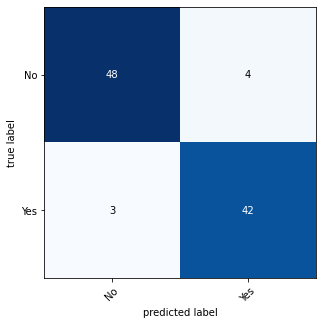

In [7]:
import matplotlib.pyplot as plt

from mlxtend.plotting import plot_confusion_matrix

fig, ax = plot_confusion_matrix(
    conf_mat=matrix,
    class_names=LABELS,
    figsize=(5, 5)
)
plt.show()

### Sensitivity and Specificity

**Specificity** is just a special case of **recall** (or **sensitivity**). Recall is calculated for the actual positive class ( TP / [TP+FN] ), whereas **specificity** is the same type of calculation but for the actual negative class ( TN / [TN+FP] ).

$precision = \frac{TP}{TP + FP}$

$recall = \frac{TP}{TP + FN}$

$F1 = 2 \cdot \frac{precision \cdot recall}{precision + recall}$

$accuracy = \frac{TP + TN}{TP + TN + FP + FN}$

$sensitivity = \frac{TP}{TP + FN}$

$specificity = \frac{TN}{TN + FP}$

In [8]:
sensitivity = matrix[1,1] / (matrix[1,1] + matrix[1,0])
specificity = matrix[0,0] / (matrix[0,0] + matrix[0,1])

print('Sensitivity:', sensitivity)
print('Specificity:', specificity)

Sensitivity: 0.9333333333333333
Specificity: 0.9230769230769231


### Area Under the Curve (AUC)

In [9]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, threshold = roc_curve(
    [ 0 if y == 'No' else 1 for y in y_labeled],
    [ 0 if y == 'No' else 1 for y in predictions]
)
roc_auc = auc(fpr, tpr)

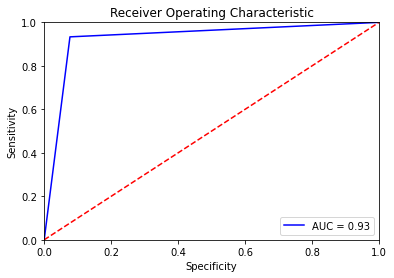

In [10]:
import matplotlib.pyplot as plt

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
#plt.ylabel('True Positive Rate')
#plt.xlabel('False Positive Rate')
plt.ylabel('Sensitivity')
plt.xlabel('Specificity')
plt.show()

---